# Mechanical  Keyboard Analysis

Matt Salinero

June 2021

---
## Overview

Over the last \~five years a community of mechanical keyboard enthusiasts has experienced rapid growth. Being a mechanical keyboard enthusiast involves researching, preordering, waiting for, and assembling exclusive mechanical keyboards from limited run keyboard components (such as keycaps, keyboard chassis, and switches). Also, mechanical keyboards can be typed on! 

At present, the market for enthusiast-level mechanical keyboard components is fragmented and largely lacks major consolidation or corporate investment. Instead, the manufacture of components is often financed using a group buy system that relies on the community preordering components to cover manufacturing costs. These group buys are often advertised on dedicated community forums, subreddits, and content creator communities dedicated to mechanical keyboards. 

However, despite group buys being publicly advertised, aggregated data on group buy sucess, failure, or popularity is not readily accessible. Much of the available information on group buys is buried in unstructured forum threads or posts. Clear trends present in the publically available data could be used by aspiring component designers to inform their choices when attempting to realize their own keycap set.

This report includes the results of an analysis of publicly posted group buys for keysets listed on community websites.

### Data Source

This analysis is based on publicly available data from [geekhack.org](https://geekhack.org/), a community forum for mechanical keyboards. The data was scraped from public forum topic posts/topic metadata and spans from 2012 to May 31, 2021. As data from 2021 is only partially collected, 2021 yearly totals cannot yet be directly compared to those from previous years.

---

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
import datetime as dt
import os
import mech_io
from pathlib import Path
%matplotlib inline

In [2]:
# variable set up
db = Path(os.path.abspath('')) / "data" / "database" / "2021-05-31_mech_db_clean.db"

# define some colors for later graphing
total_gray = '#B7B9C0'
dtotal_gray = '#898B94'
active_green = '#7AAC91'
hype_purp = '#6C3667'
pct_magen = '#A84D6F'

gmk_clr = '#9A1E2C'
pbt_clr = '#6C3667'
abs_clr = '#D76F5A'
alt_clr = '#92D2CB'

## Analysis by Year

The first stage of analysis includes establishing how many keyset group buys are being run each year and calculating some measure of success or popularity for those group buys.

To measure the popularity of a group buy, this project uses a "hype" metric, which tracks user engagement with the group buy (in the form of posting responses) near the time the group buy topic was created. A topic is considered "hyped" if it reaches 50 posts in the first 30 days, and "not hyped" if it fails to do so (i.e. hype is binary). Further detail on why this metric was chosen can be found in the project specification.

In [3]:
yearly_query = """
    /* keycap group buy yearly aggregate stats */
    SELECT
        ydata.*,
        num_icodes
    FROM (
        SELECT --this derived table calculates most rows
            STRFTIME('%Y', topic_created) as gb_year,
            COUNT(tdata.topic_id) as num_gbs,
            COUNT(DISTINCT creator_id) as num_creators,
            CAST(AVG(views) as INT) as avg_views,
            MAX(views) as max_views,
            CAST(AVG(replies) as INT) as avg_replies,
            MAX(replies) as max_replies,
            COUNT(CASE WHEN num_posts >= 25 THEN 1 END) * 100.0 
                / COUNT(tdata.topic_id) as percent_25_posts,
            COUNT(CASE WHEN num_posts >= 50 THEN 1 END) * 100.0 
                / COUNT(tdata.topic_id) as percent_50_posts,
            AVG(IFNULL(ldata.num_links, 0)) as avg_links
        --average time for gbs reaching 25/50 posts
        FROM topic_data as tdata
        LEFT JOIN (
            SELECT
                topic_id,
                COUNT(id) as num_links
            FROM topic_link
            GROUP BY topic_id
            ) ldata
        ON tdata.topic_id = ldata.topic_id
        WHERE product_type = 'keycaps'
            AND board_id = '70'
        GROUP BY gb_year
        ) ydata
    JOIN (
        SELECT --this derived table calculates number of infocodes used
            STRFTIME('%Y', topic_created) as gb_year,
            COUNT(DISTINCT icode.info_code) as num_icodes
        FROM topic_data as itdata
        JOIN topic_icode as icode
            ON itdata.topic_id = icode.topic_id
        WHERE product_type = 'keycaps'
            AND board_id = '70'
        GROUP BY gb_year
        ) iydata
    ON ydata.gb_year = iydata.gb_year
    ORDER BY gb_year;
    """

post50_query = """
    /* keycap group buy time interval stats (aggregate in python)
        - pulls topic level post_50_delta stats
        - sqlite doesn't support time intervals */
    SELECT
        topic_id,
        STRFTIME('%Y', topic_created) as gb_year,
        post_50_delta
    FROM topic_data
    WHERE product_type = 'keycaps'
            AND board_id = '70'
    ORDER BY gb_year, topic_id
    """

# connect to database and pull data
conn = sqlite3.connect(db)
yearly_df = pd.read_sql_query(yearly_query, conn, index_col="gb_year")
post50_df = pd.read_sql_query(post50_query, conn, index_col="topic_id")
conn.close()

In [4]:
# parse post_50_delta to extract day of 50th post (sqlite doesn't support time intervals)
post50_df['post_50_day'] = post50_df['post_50_delta'].apply(lambda x: mech_io.db_parse_td_str(x)['days'])

# filter topics to find hyped topics reaching 50 posts within 30 days
pop_post_df = post50_df[post50_df['post_50_day'] < 30][['gb_year', 'post_50_day']]

# aggregate across years and calculate percent
hype_df = pop_post_df.groupby(['gb_year']).count()
hype_df.rename(columns={'post_50_day':'count_hyped'}, inplace=True)
hype_df['pct_hyped'] = hype_df['count_hyped'] * 100 / yearly_df['num_gbs']

# join aggregated data with other yearly data
yearly_df = yearly_df.join(hype_df)
yearly_df.reset_index(inplace=True)

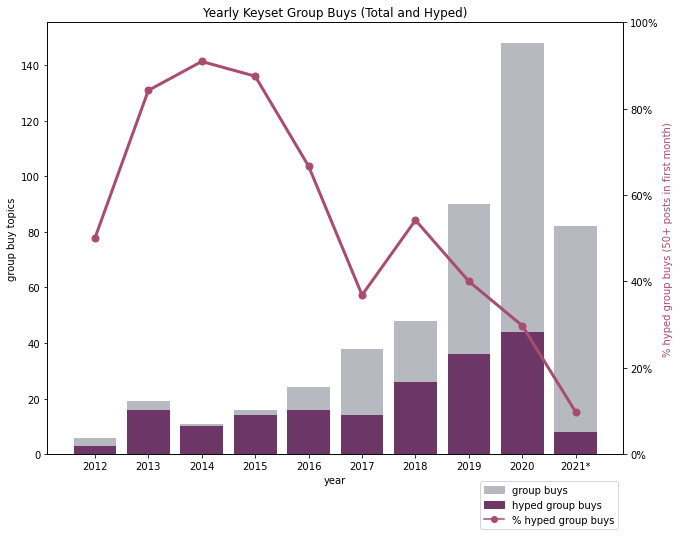

In [5]:
# yearly group buys plot

# create plot and set up twin axis
yearly_plot = plt.figure(figsize=[8,6])
yearly_ax1 = yearly_plot.add_axes([1, 1, 1, 1])
yearly_ax2 = yearly_ax1.twinx()
yearly_ax2.set_ylim(0, 100)

# plot total gbs, hyped gbs, and % popular gbs
yearly_xpos = np.arange(len(yearly_df['gb_year']))
yearly_ax1.bar(yearly_xpos, yearly_df['num_gbs'], color=total_gray)
yearly_ax1.bar(yearly_xpos, yearly_df['count_hyped'], color=hype_purp)

yearly_ax2.plot(yearly_df['gb_year'], yearly_df['pct_hyped'], 
                marker='o', linewidth=3, markersize=7, color=pct_magen)

# TODO: graph a green "active" metric (same as hyped but with 25 posts instead of 50)

# add axis labels/ticks
yearly_ax1.set_title("Yearly Keyset Group Buys (Total and Hyped)")

yearly_ax1.set_xlabel('year')
yearly_ax1.set_xticks(yearly_xpos)
yearly_xpos_lab = yearly_df['gb_year'].copy()
yearly_xpos_lab.iat[-1] = yearly_xpos_lab.iat[-1] + "*"
yearly_ax1.set_xticklabels(yearly_xpos_lab)

yearly_ax1.set_ylabel('group buy topics')
yearly_ax2.set_ylabel('% hyped group buys (50+ posts in first month)', color=pct_magen)
yearly_ax2.get_yaxis().set_major_formatter('{x:1g}%')

# add legend
gb_patch = mpatches.Patch(color=total_gray, label="group buys")
pop_patch = mpatches.Patch(color=hype_purp, label="hyped group buys")
pct_patch = mlines.Line2D([], [], color=pct_magen, marker='o', label="% hyped group buys")
yearly_plot.legend(handles=[gb_patch, pop_patch, pct_patch], 
                   bbox_to_anchor=(1, -.05, 1, 1), loc='upper right')


### Decreasing Engagement, Increasing Numbers

As shown in the graph above, the number of group buys per year has been steadily increasing (and is on pace to continue increasing in 2021) since 2014. However, the proportion of hyped group buys has been lagging behind group buy creation over the same period.
- hyped group buys increased in absolute terms through 2020, but decreased as a percentage of total group buys
    - this trend is especially significant since 2018 (early years 2012-2016 had low numbers of group buys)
- 2021 may be the first year since 2014 where there is an drop in the absolute number of hyped group buys from the previous year

A drop in average engagement of group buys could be an indicator of increasing saturation in the market. For example, if the number of consumers isn't increasing as quickly as the number of group buys, each group buy will receive less attention (and less engagement). In many cases production times (and therefore wait times) are increasing and so is competition in the form of high quality in-stock keysets.

An additional possible cause for the eroding engagement is a shift in the usage of these group buy topics. Originally, group buy topics were used for advertising basic group buy information and updates, for q&a with the creator, and for general discussion of the group buy's merits. In early years, purchases were even coordinated using forum private messages. Now, the usage of group buy topics may have contracted to focus on advertising and basic information (where the topic functions as an archive for info on the group buy).

Instead, these elements of the group buy may have moved from the group buy topic itself to other platforms related platforms.
- preorder/purchase functionality moving from the topic itself onto one or more vendor sites
- discussion/q&a etc. moving from the topic to bespoke websites, discord groups, and social media (such as Reddit and Twitch)



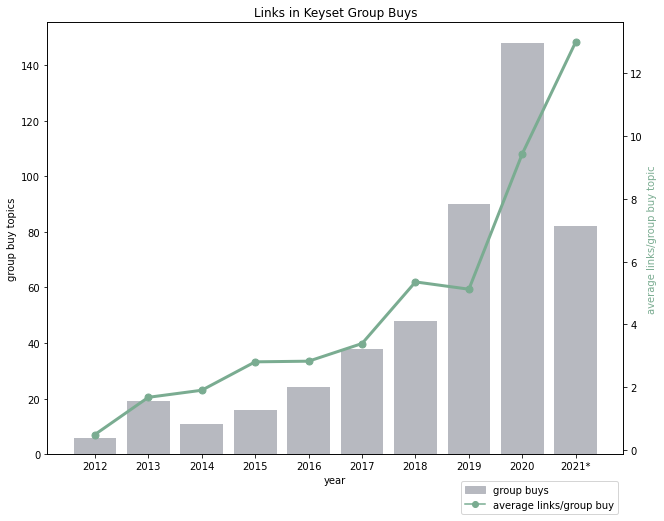

In [6]:
# links/group buy plot

# create plot and set up twin axis
links_plot = plt.figure(figsize=[8,6])
links_ax1 = links_plot.add_axes([1, 1, 1, 1])
links_ax2 = links_ax1.twinx()

# plot total gbs, links per gb
links_xpos = np.arange(len(yearly_df['gb_year']))
links_ax1.bar(links_xpos,yearly_df['num_gbs'], color=total_gray)

links_ax2.plot(yearly_df['gb_year'], yearly_df['avg_links'], 
                marker='o', linewidth=3, markersize=7, color=active_green)

# add axis labels/ticks
links_ax1.set_title("Links in Keyset Group Buys")

links_ax1.set_xlabel('year')
links_ax1.set_xticks(links_xpos)
links_xpos_lab = yearly_df['gb_year'].copy()
links_xpos_lab.iat[-1] = links_xpos_lab.iat[-1] + "*"
links_ax1.set_xticklabels(links_xpos_lab)

links_ax1.set_ylabel('group buy topics')
links_ax2.set_ylabel('average links/group buy topic', color=active_green)

# add legend
gb_patch = mpatches.Patch(color=total_gray, label="group buys")
link_patch = mlines.Line2D([], [], color=active_green, marker='o', label="average links/group buy")
links_plot.legend(handles=[gb_patch, link_patch], bbox_to_anchor=(1, -.05, 1, 1), loc='upper right')

### Links and Vendors

As shown above, there is a clear upwards trend in the number of links included in the content of a group buy topic (the first post where the creator describes the group buy). While some internal links are present in group buy topics (for example, many group buys link to a related interest check topic), most links are to outside websites such as vendor sites and discord groups (links to image sources were filtered out in this analysis). 

- a vendor site is a page where a user can purchase/preorder the group buy product
- many group buys (especially recently) feature multiple vendors, including:
    - regional proxies for multiple regions (this is contributor to the increase in links)
    - separate tie-in product vendors selling, for example, matching deskmats and cables

However, it is important to recognize that this isn't necessarily a causal link - group buy creators might be resorting to adding vendors etc. as a means of increasing sales due to poor discoverability on the forum. However, there may be somewhat of a vicious cycle going on, where creators add other platforms,drive less and less people to visit group buy topics, which sparks other creators to de-emphasize the forum further.

In [7]:
discord_query = """
    /* yearly expanded domain/vendor data */
    SELECT
        CASE
            WHEN link LIKE '%discord%' THEN 'discord.gg'
            WHEN LOWER(domain) LIKE ('%' || REPLACE(LOWER(set_name), ' ', '') || '%')
                THEN 'custom domain'
            ELSE LOWER(domain)
        END as domain_type,
        STRFTIME('%Y', tdata.topic_created) as gb_year,
        COUNT(DISTINCT ldata.topic_id) as num_topics,
        COUNT(id) as num_occurances
    FROM topic_link as ldata
    JOIN topic_data as tdata
        ON ldata.topic_id = tdata.topic_id
    WHERE domain_type = 'discord.gg'
    GROUP BY domain_type, gb_year
    ORDER BY gb_year;
    """

# connect to database and pull data
conn = sqlite3.connect(db)
discord_df = pd.read_sql_query(discord_query, conn)
conn.close()

In [8]:
# prep discord data for graphing over full set of years

# join with total number of gbs for each year
discord_years = yearly_df.set_index('gb_year')['num_gbs']
discord_df = discord_df.set_index('gb_year').join(discord_years, how='right')
# discord_df.fillna(value=0, inplace=True)
discord_df.reset_index(inplace=True)

# calculate % of gbs mentioning discord
discord_df['pct_discord'] = discord_df['num_topics'] * 100 / discord_df['num_gbs']



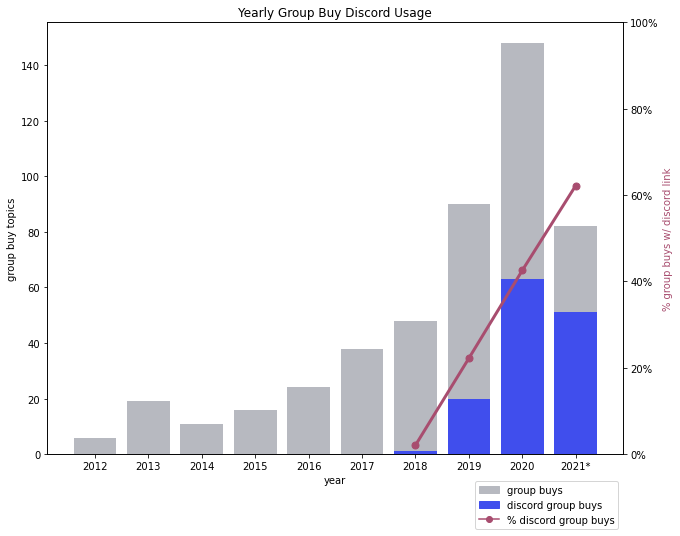

In [9]:
# yearly discord link plot
dcrd_blue = '#404EED'

# create plot and set up twin axis
dcrd_plot = plt.figure(figsize=[8,6])
dcrd_ax1 = dcrd_plot.add_axes([1, 1, 1, 1])
dcrd_ax2 = dcrd_ax1.twinx()

# plot total gbs, discord gbs, and % discord gbs
dcrd_xpos = np.arange(len(discord_df['gb_year']))
dcrd_ax1.bar(dcrd_xpos, discord_df['num_gbs'], color=total_gray)
dcrd_ax1.bar(dcrd_xpos, discord_df['num_topics'], color=dcrd_blue)

dcrd_ax2.plot(discord_df['gb_year'], discord_df['pct_discord'], 
                marker='o', linewidth=3, markersize=7, color=pct_magen)

# add axis labels/ticks
dcrd_ax1.set_title("Yearly Group Buy Discord Usage")

dcrd_ax1.set_xlabel('year')
dcrd_ax1.set_xticks(dcrd_xpos)
dcrd_xpos_lab = discord_df['gb_year'].copy()
dcrd_xpos_lab.iat[-1] = dcrd_xpos_lab.iat[-1] + "*"
dcrd_ax1.set_xticklabels(dcrd_xpos_lab)

dcrd_ax1.set_ylabel('group buy topics')
dcrd_ax2.set_ylabel('% group buys w/ discord link', color=pct_magen)
dcrd_ax2.get_yaxis().set_major_formatter('{x:1g}%')
dcrd_ax2.set_ylim(0, 100)

# create legend
gb_patch = mpatches.Patch(color=total_gray, label="group buys")
dcrd_patch = mpatches.Patch(color=dcrd_blue, label="discord group buys")
pct_patch = mlines.Line2D([], [], color=pct_magen, marker='o', label="% discord group buys")
dcrd_plot.legend(handles=[gb_patch, dcrd_patch, pct_patch], 
                 bbox_to_anchor=(1, -.05, 1, 1), loc='upper right')

### Discord Groups for Group Buys

The first detected instance of a discord link included in a group buy topic was in 2018 and since then the number of group buys including some form of discord has rapidly increased. The majority of 2021 group buys to date now contain discord links.

- this trend mirrors the precipitous drop in hyped group buys since 2018 as previously explored
- discord groups can replace the general discussion and q&a previously done within the group buy topic
    - discord provides more constant responses, a platform users are constantly idling on, notifications, etc.

---

## Group Buy - Interest Check Analysis

The next stage of analysis looked at the intersection of group buy topics and preceding interest check topics. Analysis of these GB-IC matches provided insights into how a preceding interest check can predict the performance of an eventual group buy. This analysis matched group buys with interest checks based on the name of the keyset referenced in the title of the group buy/interest check. Further detail on how interest checks were matched with group buys can be found in the project specification.

In [10]:
match_query = """
    /* group buy interest check match data */
    WITH --cte to get base view with full_name and data relevant for matching
        full_data (
            topic_id, 
            board, 
            info_code, 
            set_name, 
            full_name, 
            creator,
            creator_id, 
            topic_created, 
            num_links, 
            views, 
            replies, 
            topic_rank
            )
        AS (
            SELECT
                tdata.topic_id,
                CASE
                    WHEN tdata.board_id = '70' THEN 'gb'
                    WHEN tdata.board_id = '132' THEN 'ic'
                END as board,
                icode.info_code,
                set_name,
                icode.info_code || ' ' || set_name as full_name,
                creator,
                creator_id,
                DATETIME(topic_created) as topic_created,
                IFNULL(ldata.num_links, 0) as num_links,
                views,
                replies,
                ROW_NUMBER() OVER( 
                    PARTITION BY info_code, UPPER(set_name) 
                    ORDER BY CAST(tdata.topic_id as INT)
                    ) as topic_rank --lists if first, second etc. gb/ic
            FROM topic_data as tdata
            JOIN (
                SELECT --pulls first/primary infocode
                    topic_id,
                    info_code,
                    ROW_NUMBER() OVER(PARTITION BY topic_id) as row_num
                FROM topic_icode
                ) icode
                ON tdata.topic_id = icode.topic_id
                    AND icode.row_num = 1
            LEFT JOIN (
                SELECT --aggregates total number of links in post
                    topic_id,
                    COUNT(link) as num_links
                FROM topic_link
                GROUP BY topic_id
                ) ldata
                ON tdata.topic_id = ldata.topic_id
            WHERE product_type = 'keycaps'
        )
    SELECT
        gbdata.topic_id as gb_topic_id,
        icdata.topic_id as ic_topic_id,
        IFNULL(gbdata.full_name, icdata.full_name) as full_name,
        IFNULL(gbdata.creator, icdata.creator) as creator,
        CASE --used for later filter based on recency
            WHEN STRFTIME('%Y', gbdata.topic_created) IN ('2018', '2019', '2020', '2021')
                THEN 'recent'
            ELSE 'not_recent'
        END as era,
        gbdata.topic_created,
        gbdata.num_links,
        gbdata.views as gb_views,
        icdata.views as ic_views,
        gbdata.replies as gb_replies,
        icdata.replies as ic_replies,
        gbdata.topic_rank,
        CAST(IFNULL(gbdata.topic_id, icdata.topic_id) as INT) as order_calc
    FROM (
        SELECT *
        FROM full_data
        WHERE board = 'gb'
        ) gbdata
    JOIN ( --take only matches for this
        SELECT *
        FROM full_data
        WHERE board = 'ic'
        ) icdata
        ON gbdata.full_name = icdata.full_name
            AND gbdata.topic_rank = (icdata.topic_rank + 1)
    ORDER BY order_calc;
    """

# connect to database and pull data
conn = sqlite3.connect(db)
match_df = pd.read_sql_query(match_query, conn)
conn.close()

In [11]:
# fit regression lines based on year

match_old_fit, old_stats = np.polynomial.polynomial.Polynomial.fit(
               match_df[match_df['era'] == 'not_recent']['ic_replies'], 
               match_df[match_df['era'] == 'not_recent']['gb_replies'], 1, full=True)
match_rec_fit = np.polynomial.polynomial.Polynomial.fit(
               match_df[match_df['era'] == 'recent']['ic_replies'], 
               match_df[match_df['era'] == 'recent']['gb_replies'], 1)
match_xpos = np.linspace(0, 1000)

# TODO: get the r of these regressions in here somehow (use old_stats)

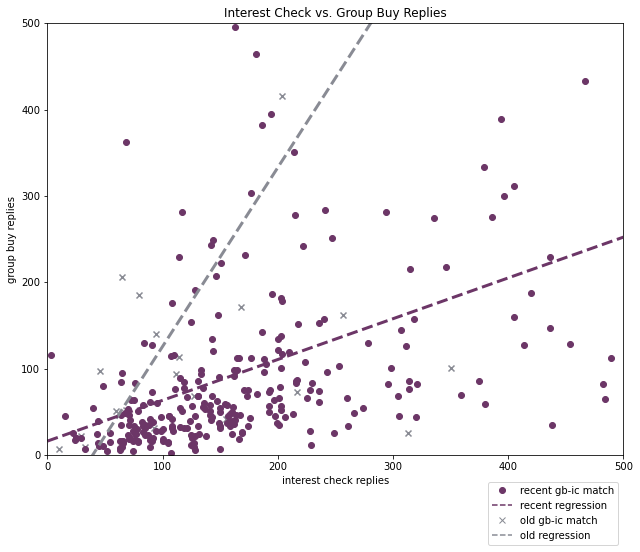

In [12]:
# gb-ic match plot

# create plot and set up twin axis
match_plot = plt.figure(figsize=[8,6])
match_ax1 = match_plot.add_axes([1, 1, 1, 1])

# plot ic replies vs. gb replies for matching topics
match_ax1.scatter(match_df[match_df['era'] == 'not_recent']['ic_replies'], 
                  match_df[match_df['era'] == 'not_recent']['gb_replies'], 
                  marker='x', color=dtotal_gray)
match_ax1.scatter(match_df[match_df['era'] == 'recent']['ic_replies'], 
                  match_df[match_df['era'] == 'recent']['gb_replies'], 
                  marker='o', color=hype_purp)
match_ax1.plot(match_xpos, match_old_fit(match_xpos),  
               marker='', linewidth=3, linestyle='dashed', color=dtotal_gray)
match_ax1.plot(match_xpos, match_rec_fit(match_xpos),  
               marker='', linewidth=3, linestyle='dashed', color=hype_purp)

# add axis labels/ticks
match_ax1.set_title("Interest Check vs. Group Buy Replies")

match_ax1.set_xlabel('interest check replies')
match_ax1.set_xlim(0, 500)

match_ax1.set_ylabel('group buy replies')
match_ax1.set_ylim(0, 500)

# TODO: outlier effect on old regression?

# create legend
rec_patch = mlines.Line2D([], [], color=hype_purp, marker='o', 
                          linewidth=0, label="recent gb-ic match")
rec_fit_patch = mlines.Line2D([], [], color=hype_purp, marker='', 
                          linestyle='dashed', label="recent regression")
old_patch = mlines.Line2D([], [], color=dtotal_gray, marker='x', 
                          linewidth=0, label="old gb-ic match")
old_fit_patch = mlines.Line2D([], [], color=dtotal_gray, marker='', 
                          linestyle='dashed', label="old regression")
match_plot.legend(handles=[rec_patch, rec_fit_patch, old_patch, old_fit_patch], 
                  bbox_to_anchor=(1, -.05, 1, 1), loc='upper right')

### GB-IC Response Correlation

- split into two eras, the creatively named "recent" (2018 and newer) and "old" (2017 and before) eras
- large delta between recent and old trends

---

In [13]:
# TODO: look at interest checked vs non interest check hype metrics
# TODO: could also look aat interest checks by year (for topics with a corresponding group buy)

## Analysis by Infocode

"Info codes" are short abbreviations containing key information about a keyset. Commonly infocodes encode keycap profile, material, and/or manufacturer information for the keyset. Analysis of infocodes provides an accessible way to determine what types of group buys are being run.

There are dozens of info codes that have been used to characterize keysets (many only appearing rarely). To make the analysis more managable, each known infocode was separated into one of four broad categories for analysis:
- **GMK**: the most common single infocode, represents a manufacturer producing high quality cherry-profile keycaps out of ABS plastic
- **ABS** (non-GMK): non-GMK produced ABS cherry-profile keycaps
- **PBT**: cherry-profile keycaps made from PBT plastic
- **alt profile**: keycaps using a non-cherry profile (includes high profile and uniform keycap styles)

In [14]:
icode_query = """
    /* categorical yearly icode data */
    WITH cat_icode (topic_id, cat, info_code, topic_created) as (
        SELECT
            icode.topic_id as topic_id,
            CASE
                WHEN icode.info_code = 'GMK'
                    THEN 'GMK'
                WHEN icode.info_code in ('PBT', 'EPBT', 'IFK', 'CRP', 'GA')
                    THEN 'PBT'
                WHEN icode.info_code in ('JTK', 'DCS', 'TH')
                    THEN 'ABS'
                WHEN icode.info_code in ('MG', 'SA', 'SP', 'HSA', 'KAT', 'KAM',
                    'DSA', 'MDA', 'XDA')
                    THEN 'alt'
                ELSE 'other'
            END as cat,
            icode.info_code as info_code,
            tdata.topic_created as topic_created
        FROM topic_icode as icode
        JOIN topic_data as tdata
            ON icode.topic_id = tdata.topic_id
        WHERE board_id = '70'
        )
    SELECT
        cat,
        STRFTIME('%Y', topic_created) as gb_year,
        COUNT(DISTINCT topic_id) as occurances
    FROM cat_icode
    GROUP BY cat, gb_year
    ORDER BY gb_year;
    """

# connect to database and pull data
conn = sqlite3.connect(db)
icode_df = pd.read_sql_query(icode_query, conn)
conn.close()

In [15]:

icode_gmk = icode_df[icode_df['cat'] == 'GMK'][['gb_year', 'occurances']]
icode_gmk.rename(columns={'occurances': 'GMK'}, inplace=True)

icode_pbt = icode_df[icode_df['cat'] == 'PBT'][['gb_year', 'occurances']]
icode_pbt.rename(columns={'occurances': 'PBT'}, inplace=True)

icode_abs = icode_df[icode_df['cat'] == 'ABS'][['gb_year', 'occurances']]
icode_abs.rename(columns={'occurances': 'ABS'}, inplace=True)

icode_alt = icode_df[icode_df['cat'] == 'alt'][['gb_year', 'occurances']]
icode_alt.rename(columns={'occurances': 'alt'}, inplace=True)

icode_wide = icode_gmk.merge(icode_pbt, how='outer', on='gb_year', sort=True)\
                .merge(icode_abs, how='outer', on='gb_year')\
                .merge(icode_alt, how='outer', on='gb_year')

icode_wide.fillna(value=0, inplace=True)

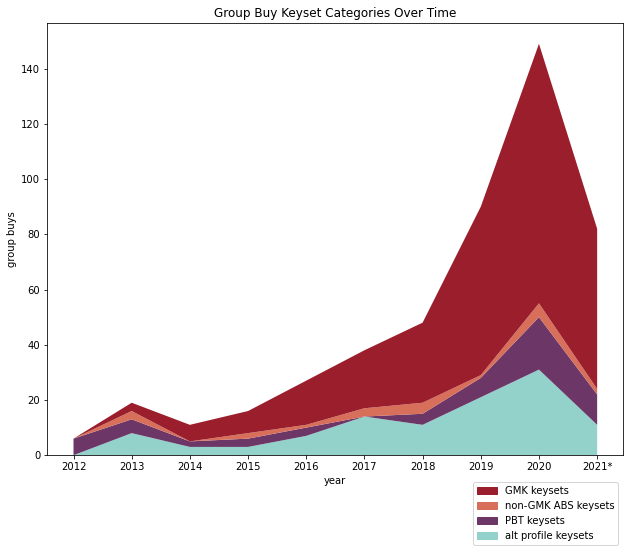

In [16]:
# infocode stats stackplot

# create plot and set up twin axis
icode_plot = plt.figure(figsize=[8,6])
icode_ax1 = icode_plot.add_axes([1, 1, 1, 1])

# plot infocode categories as a stackplot
icode_ax1.stackplot(icode_wide['gb_year'], icode_wide['alt'], icode_wide['PBT'], icode_wide['ABS'], icode_wide['GMK'],
                    colors=[alt_clr, pbt_clr, abs_clr, gmk_clr])

# add axis labels/ticks
icode_ax1.set_title("Group Buy Keyset Categories Over Time")

icode_ax1.set_xticks(icode_wide['gb_year'])
icode_xpos_lab = icode_wide['gb_year'].copy()
icode_xpos_lab.iat[-1] = icode_xpos_lab.iat[-1] + "*"
icode_ax1.set_xticklabels(icode_xpos_lab)
icode_ax1.set_xlabel('year')

icode_ax1.set_ylabel('group buys')

# create legend
gmk_patch = mpatches.Patch(color=gmk_clr, label='GMK keysets')
abs_patch = mpatches.Patch(color=abs_clr, label='non-GMK ABS keysets')
pbt_patch = mpatches.Patch(color=pbt_clr, label='PBT keysets')
alt_patch = mpatches.Patch(color=alt_clr, label='alt profile keysets')

icode_plot.legend(handles=[gmk_patch, abs_patch, pbt_patch, alt_patch], 
                  bbox_to_anchor=(1, -.05, 1, 1), loc='upper right')

### Infocode Categories Over Time

Initially, the analysis looked at the yearly number of group buys for each infocode category. Unsurprisingly, GMK was the most common category, but some other useful insights also emerged from this view of the data. 

- the number of group buys across all categories (except non-GMK ABS) has steadily increased since 2018
    - percentage analysis can confirm, but the 2018-2021 increase group buys numbers appears to apply universally across categories
- non-GMK ABS group buys have registed consistently low numbers of group buys since 2012
    - not really a niche for these keycaps, GMK is the quality benchmark for ABS cherry profile keycaps
    - no shortage of GMK group buys, so there either non-GMK ABS can't meaningfully differentiate or there's little capacity active outside of GMLK
- PBT group buys were also low popularity (similar to non-GMK ABS) until 2018
    - after 2018, PBT group buy numbers increase along with the rest of the market
    - PBT keysets were around pre-2018, but weren't the focus for group buys
        - PBT is harder to work with than ABS, so potentially less ability to do small volume runs for specialized group buys

In [17]:
# convert raw info code data into percent data
icode_y_sum = icode_wide.set_index('gb_year').sum(axis=1)
icode_pct = icode_wide.set_index('gb_year').divide(icode_y_sum, axis=0) * 100
icode_pct.reset_index(inplace=True)

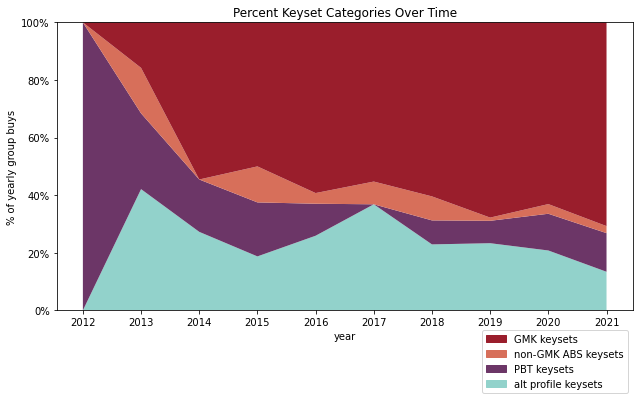

In [18]:
# infocode percentage stackplot

# create plot and set up twin axis
icode_pct_plot = plt.figure(figsize=[8,4])
icode_pct_ax1 = icode_pct_plot.add_axes([1, 1, 1, 1])

# plot infocode categories as a stackplot showing % of total gbs
icode_pct_ax1.stackplot(icode_pct['gb_year'], icode_pct['alt'], icode_pct['PBT'], icode_pct['ABS'], icode_pct['GMK'],
                    colors=[alt_clr, pbt_clr, abs_clr, gmk_clr])

# add axis labels/ticks
icode_pct_ax1.set_title("Percent Keyset Categories Over Time")

icode_pct_ax1.set_xticks(icode_pct['gb_year'])
icode_pct_xpos_lab = icode_pct['gb_year'].copy()
icode_xpos_lab.iat[-1] = icode_pct_xpos_lab.iat[-1] + "*"
icode_pct_ax1.set_xticklabels(icode_pct_xpos_lab)
icode_pct_ax1.set_xlabel('year')

icode_pct_ax1.set_ylabel('% of yearly group buys')
icode_pct_ax1.get_yaxis().set_major_formatter('{x:1g}%')
icode_pct_ax1.set_ylim(0, 100)

# create legend
gmk_patch = mpatches.Patch(color=gmk_clr, label='GMK keysets')
abs_patch = mpatches.Patch(color=abs_clr, label='non-GMK ABS keysets')
pbt_patch = mpatches.Patch(color=pbt_clr, label='PBT keysets')
alt_patch = mpatches.Patch(color=alt_clr, label='alt profile keysets')

icode_pct_plot.legend(handles=[gmk_patch, abs_patch, pbt_patch, alt_patch], 
                      bbox_to_anchor=(1, -.05, 1, 1), loc='upper right')

### Infocode Category Share

After looking at raw numbers, focus turned to the percentage share of group buys in each category. The yearly percentage distribution of different infocodes can tell a story about how the preferences of the community are evolving. However, after some early variability form 2012-2014 (in years that featured <20 group buys total), the overall percentages of each category of group buy have remained largely stable to the present.

- importantly, the percentages of each category of group buy remained stable throughout the 2018-2021 increase
    - this result confirms idea that the recent increase in popularity is not disproportionally driven by one category of keyset
        - while GMK added the most new group buys year over year, GMK was already the most popular category
    - however, this analysis doesn't consider sales, only how many group buys of a given type are being run
        - the sales data (if it was available) could tell a very different story
- it will be interesting to see if this status quo can hold up going forwards 
    - open question of whether ever increasing numbers of GMK group buys can continue to be run 
    - already reports of increasing production backlog at GMK
- in general, 20-30% of group buys are for "alternate profiles" (high profiles and uniform keycaps), with the remaining group buys featuring a standard Cherry profile (or another similar profile)

---

In [19]:
# round 2 timing
# graph time since previous round vs previous round replies? views?
# 

## Results and Takeaways

#### Less Focus on the Forum
Despite massive increases in the total number of group buys being run in recent years, engagement on the forum has been steadily eroding. 
- if running a group buy, look to establish other platforms for discussion in addition to the group buy/info check topics
    - discord seems to be increasingly attractive (if partnered with a popular vendor or other large community)
    - advertising on other social media may also be necessary, as the community seems to spend the majority of its time elsewhere
- if a group buy customer, the forums still seems good for discovery, but other platforms (such as a discord group) may be more responsive for asking questions

#### Infocodes as They've Always Been
Across the gathered data, the distribution of infocode categories among group buys was overall stable at:

- ~65% GMK (Cherry profile)
- <5% non-GMK ABS (Cherry profile)
- ~10% PBT (Cherry profile)
- ~20% alternative profiles

GMK group buys make up most of the overall market for group buys and virtually all ABS cherry profile group buys. However, there's still steady demand for the other categories. While GMK's dominance seems set to continue into the future, the other categories aren't dying out and are growing at a rate roughly proportional to the overall number of group buys.
